In [ ]:
import math
from itertools import product
import autograd.numpy as np
from autograd import grad
from numpy import linalg as LA
import matplotlib.pyplot as plt
from functools import partial


In [ ]:
def LaGrange(X, Y):
    n = len(X)
    L = np.poly1d([0])
    for i in range(n):
        pn = np.poly1d(Y[i])
        for j in range(n):
            if i != j:
                factor = X[i] - X[j]
                pn = np.polymul(pn, np.poly1d([1, -X[j]]) / factor)
        L = np.polyadd(L, pn)
    return L

# interpolate is used for plotting by evaluating our Lagrange polynomial
# iters number of points.
# A is the x values for which we want to plot.
def interpolate(X, Y, start, end, iters):
    L = LaGrange(X, Y)
    A = equidist(start, end, iters)
    return [L(A[i]) for i in range(iters)]


In [141]:
# The poly1d approach for the implementation of Lagrange-interpolation
# started to behave really badly for high degree polynomials.
# Decided to write a different implementation
# X is an array containing the nodes for interpolation
# f is the function which we are trying to approximate (we only evaluate f in our nodes
# because in theory we don't necesarrily know it for other values)
def LaGrange2(X, f, x):
    n = len(X)
    L = []
    terms = []
    np.array(L)
    np.array(terms)
    for k in range(n):
        factors = [(x - X[i]) / (X[k] - X[i]) for i in range(n) if (X[i] != X[k])]
        L.append(np.product(factors))
        terms.append(L[k]*f(X[k]))
    return lambda x: sum(terms)


# Evaluates LaGrange2 in a specific x
def eval(X, f, x):
    return LaGrange2(X, f, x)(x)


# interpolate2 is like interpolate, but for the second implementation of the lagrange poly
# A is the x values for which we want to plot.
def interpolate2(X, f, start, end, iters):
    A = equidist(start, end, iters)
    return [eval(X, f, A[i]) for i in range(iters)], A


# Here a,b are the bounds, K the number of subintervals used, n the number of nodes in
# each subinterval and f the function we are approximating.
def piecewiseLaGrange(a, b, K, x, n, f):
    i = a
    X = []
    while i < b:
        X.append([i, i + (b - a) / K])
        i += (b - a) / K
    for y in X:
        if x <= y[1]:
            return eval(equidist(y[0], y[1], n), f, x)


# A is the x values for which we want to plot.
def interpolate_piecewise(start, end, iters, K, n, f):
    A = equidist(start, end, iters)
    return [piecewiseLaGrange(start, end, K, A[i], n, f) for i in range(iters)]

In [138]:
# a,b interval bounds, n number of nodes
def equidist(a, b, n):
    return np.asarray(np.linspace(a, b, n))


# a,b interval bounds, n number of nodes
def chebyshev(a, b, n):
    return np.asarray([1 / 2 * (a + b) + 1 / 2 * (b - a) * math.cos((2 * k - 1) / (2 * n) * math.pi) for k in range(1, n+1)])


def runge(x):
    return 1 / (x**2 + 1)


def rad_function(x):
    return 3/4 * (np.exp(-((9 * x - 2)**2) / 4) + np.exp(-((9*x-2)**2)/49)) + 1/2 * (np.exp((-(9*x-7)**2)/4)) - 1/10*(np.exp((9*x-4)**2))


# This function calculates the max-norm or supremum norm of the difference of two scalars
def approxInfNorm(fx, p_n):
    return np.linalg.norm(abs(fx - p_n), np.inf)


# This function calculates the two-norm or square norm of the difference of two scalars
def approx2norm(fx, p_n):
    return np.linalg.norm(abs(fx - p_n), 2)


# This function evaluates a function f in every point in an array X
def func_values(f, X):
    return np.asarray([f(x) for x in X])


def func_values2(f, X):
    return np.asarray([[x,f(x)] for x in X])


def F(x):
    return np.cos(2 * np.pi * x)


def G(x):
    return np.exp(3 * x) * np.sin(2 * x)

In [149]:
# This function calculates the approximated error of an interpolated polynomial against
# the number of nodes used for interpolation. Even though this in practice can take any
# function as input, it is made for F(x), because hardcoding the theoretic error bound was
# was easier.
def error_vs_n(N, f, norm, nodetype):
    M = []
    theoretic = []
    for i in range(1, N):
        X = equidist(0, 1, 100 * i)
        fx = func_values(f, X)
        p_n,_ = interpolate2(nodetype(0, 1, i), f, 0, 1, 100 * i)
        M.append(norm(fx, p_n))
        theoretic.append((2 * np.pi)**(i + 1) / (math.factorial(i + 1)))
    return M, theoretic


def expError(N, f, norm, nodetype):
    M = []
    for i in range(1, N):
        X = equidist(0, np.pi/4, 100 * i)
        fx = func_values(f, X)
        p_n,_ = interpolate2(nodetype(0, np.pi/4, i), f, 0, np.pi/4, 100 * i)
        M.append(norm(fx, p_n))
    return M

# This also calculates the approximated error, but for piecewise interpolation.
# K - number of subintervals, n - number of noodes in each subinterval.
def expError2(K, norm, n):
    M = []
    X = equidist(0, math.pi/4, 1000)
    for i in range(1, K):
        fx = func_values(G, X)
        p_n = interpolate_piecewise(0, math.pi/4, 100*n, i, n, G)
        #print(p_n)
        M.append(norm(fx, p_n))
    return M

In [163]:
# The function p() is a convenient way to make the global variables for gradient descent.
def p():
    """
    f is the function
    a is start of domain
    b is end of domain
    N is the number of known points
    K is the known points (c_k in the problem description) 
    """
    p.f, p.a, p.b, p.N, p.K = F, 0., 1., 1000, nodes2


# Cost function for gradient descent in problem d)
def cost(X):
    cost = 0
    for k in range(0, len(p.K)):
        cost = cost + (p.f(k)-eval(X, p.f, p.K[k]))**2
    return (p.b-p.a)/p.N*cost


# Gradient descent with backtracking for problem d)
# L -- initial parameter, hyp1, hyp2 -- hyperparameters, iters -- the number of iterations in
# the outer loop. I do ten times the amount of iterations in the inner loop, because
# the calculation of the gradient in the outer loop is very slow.
def grad_descent(nodes, L, hyp1, hyp2, iters):
    gradient = grad(cost)
    phi = cost(nodes)
    count = 0
    for k in range(iters):
        g = gradient(nodes)
        count = count+1
        print(count)
        for t in range(iters*10):
            X = nodes
            x2 = X - 1/L*g
            phi2 = cost(x2)
            if phi2 <= (phi + np.dot(g, x2-X) + L/2*np.linalg.norm(x2-X, 2)):
                nodes = (x2)
                phi = phi2
                L = hyp2*L
                break
            else:
                L = hyp1*L
    return nodes


# p2() is as p(), but for the radial basis function in problem e)
def p2():
    """
      f is the function
      a is start of domain
      b is end of domain
      N is the number of known points
      K is the known points (c_k in the problem description)
      """
    p2.f, p2.a, p2.b, p2.N, p2.K = runge, 0., 1., 1000, nodes2


def phi(r, epsilon):
    return np.exp(-(epsilon*r)**2)


#In this function we create the matrix M and solve w=M^{-1}f
def weight(X):
    M = np.array([[phi(abs(X[i] - X[j]), X[len(X) - 1]) for j in range(len(X) - 1)] for i in range(len(X) - 1)])
    W = np.linalg.solve(M, func_values(p2.f, nodes))
    return W


# This function calculates the radial basis function and evaluates it in a point e
def radial_basis(X, e):
    sum = 0
    W = weight(X)
    for i in range(0, len(X)-1):
        sum = sum + W[i]*phi(np.abs(e-X[i]), X[len(X)-1])
    return sum


def interpolate3(X, start, end, iters):
    #X = np.append(X, np.inf)
    A = equidist(start, end, iters)
    return [radial_basis(X, A[i]) for i in range(iters)], A


# This function calculates the cost of the radial basis function
def radial_cost(X):
    cost = 0
    for k in range(0, len(p2.K)):
        cost = cost + (p2.f(p2.K[k])-radial_basis(X, p2.K[k]))**2
    return (p2.b-p2.a)/p2.N*cost


# This is gradient descent for radial basis function instead of Lagrange. They are pretty
# much identical.
def grad_descent2(nodes, L, hyp1, hyp2, iters):
    gradient = grad(radial_cost)
    phi = radial_cost(nodes)
    for k in range(iters):
        g = gradient(nodes)
        print('count')
        for t in range(iters):
            X = nodes
            x2 = X - 1/L*g
            phi2 = radial_cost(x2)
            if phi2 <= (phi + np.dot(g, x2-X) + L/2*np.linalg.norm(x2-X, 2)):
                nodes = (x2)
                phi = phi2
                L = hyp2*L
                break
            else:
                L = hyp1*L
    return nodes


# I use this function for plotting error vs nodes with gradient descent optimised nodes
def grad_error_vs_n(N, f, norm):
    M = []
    for i in range(1, N):
        p()
        X = equidist(0, 1, 1000)
        fx = func_values(f, X)
        g = grad_descent(equidist(0,1,i), 100., 1.7, 0.8, 40)
        p_n,_ = interpolate2(g, f, 0, 1, 1000)
        M.append(norm(fx, p_n))
    return M


# I use this function for plotting error vs nodes with gradient descent optimised nodes
def grad2_error_vs_n(N, f, norm):
    M = []
    for i in range(2, N):
        p2(equidist(-1,1,i))
        #print(p2.nodes)
        X = np.append(p2.nodes, 3.)
        X2 = equidist(-1, 1, 1000)
        fx = func_values(f, X2)
        g, Co = grad_descent2(X, 100, 2., 0.9, 40)
        p_n,_ = interpolate3(g, -1, 1, 1000)
        M.append(norm(fx, p_n))
    return M


# I use this function for plotting error vs nodes for rbf-approximated functions.
def rbf_error_vs_n(N, f, norm, nodetype):
    M = []
    for i in range(2, N):
        p2(nodetype(-1,1,i))
        X2 = equidist(-1,1,1000)
        X = np.append(p2.nodes, 3.)
        fx = func_values(f,X2)
        p_n,_ = interpolate3(X, -1,1,1000)
        M.append(norm(fx, p_n))
    return M


nodes = equidist(0, 1, 10)
nodes2 = equidist(0, 1, 1000)


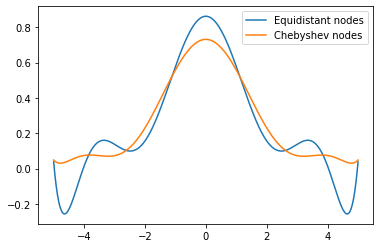

In [151]:
# This code creates Figure 1
rungeplotEq,_ = interpolate2(equidist(-5, 5, 10), runge, -5., 5., 1000)
rungeplotChe,A = interpolate2(chebyshev(-5, 5, 10), runge, -5, 5, 1000)
plt.plot(A, rungeplotEq, label = 'Equidistant nodes')
plt.plot(A, rungeplotChe, label = 'Chebyshev nodes')
plt.legend()
plt.show()

In [158]:
# This code creates Figure 2
'''
errors, theoretical = error_vs_n(50, F, approxInfNorm, equidist)
errors2,_ = error_vs_n(50, F, approx2norm, equidist)

plt.semilogy(errors, "r", label = 'sup error Chebyshev nodes')
plt.semilogy(errors2, "b", label = 'square error Chebyshev nodes')
plt.semilogy(theoretical, label = 'theoretical error bound')
plt.ylabel("error")
plt.xlabel('number of nodes')
plt.legend()
plt.show()
'''

'\nerrors, theoretical = error_vs_n(50, F, approxInfNorm, equidist)\nerrors2,_ = error_vs_n(50, F, approx2norm, equidist)\n\nplt.semilogy(errors, "r", label = \'sup error Chebyshev nodes\')\nplt.semilogy(errors2, "b", label = \'square error Chebyshev nodes\')\nplt.semilogy(theoretical, label = \'theoretical error bound\')\nplt.ylabel("error")\nplt.xlabel(\'number of nodes\')\nplt.legend()\nplt.show()\n'

In [160]:
# This code creates Figure 3
'''
errors, theoretical = error_vs_n(50, F, approxInfNorm, chebyshev)
errors2,_ = error_vs_n(50, F, approx2norm, chebyshev)

plt.semilogy(errors, "r", label = 'sup error Chebyshev nodes')
plt.semilogy(errors2, "b", label = 'square error Chebyshev nodes')
plt.semilogy(theoretical, label = 'theoretical error bound')
plt.ylabel("error")
plt.xlabel('number of nodes')
plt.legend()
plt.show()
'''

'\nerrors, theoretical = error_vs_n(50, F, approxInfNorm, chebyshev)\nerrors2,_ = error_vs_n(50, F, approx2norm, chebyshev)\n\nplt.semilogy(errors, "r", label = \'sup error Chebyshev nodes\')\nplt.semilogy(errors2, "b", label = \'square error Chebyshev nodes\')\nplt.semilogy(theoretical, label = \'theoretical error bound\')\nplt.ylabel("error")\nplt.xlabel(\'number of nodes\')\nplt.legend()\nplt.show()\n'

In [161]:
# This code creates Figure 4
'''
plt.figure()
G_errors = expError(50, G, approxInfNorm, equidist)
G_errors2 = expError(50, G, approx2norm, equidist)

plt.semilogy(G_errors, "r", label = 'sup norm equidistant nodes')
plt.semilogy(G_errors2, "b", label = 'square error norm equidistant nodes')
plt.xlabel('number of nodes')
plt.ylabel('error')
plt.legend()
plt.show()
'''

'\nplt.figure()\nG_errors = expError(50, G, approxInfNorm, equidist)\nG_errors2 = expError(50, G, approx2norm, equidist)\n\nplt.semilogy(G_errors, "r", label = \'sup norm equidistant nodes\')\nplt.semilogy(G_errors2, "b", label = \'square error norm equidistant nodes\')\nplt.xlabel(\'number of nodes\')\nplt.ylabel(\'error\')\nplt.legend()\nplt.show()\n'

In [162]:
# This code creates Figure 5
'''
plt.figure()
G_errors = expError(50, G, approxInfNorm, chebyshev)
G_errors2 = expError(50, G, approx2norm, chebyshev)

plt.semilogy(G_errors, "r", label = 'sup norm equidistant nodes')
plt.semilogy(G_errors2, "b", label = 'square error norm equidistant nodes')
plt.xlabel('number of nodes')
plt.ylabel('error')
plt.legend()
plt.show()
'''

'\nplt.figure()\nG_errors = expError(50, G, approxInfNorm, chebyshev)\nG_errors2 = expError(50, G, approx2norm, chebyshev)\n\nplt.semilogy(G_errors, "r", label = \'sup norm equidistant nodes\')\nplt.semilogy(G_errors2, "b", label = \'square error norm equidistant nodes\')\nplt.xlabel(\'number of nodes\')\nplt.ylabel(\'error\')\nplt.legend()\nplt.show()\n'

In [ ]:
# This code creates Figure 6

'''
sup1node = expError2(100, approxInfNorm, 1)
sup2node = expError2(100, approxInfNorm, 2)
sup3node = expError2(100, approxInfNorm, 3)
sup4node = expError2(100, approxInfNorm, 4)
sup5node = expError2(100, approxInfNorm, 5)
sup6node = expError2(100, approxInfNorm, 6)
sup7node = expError2(100, approxInfNorm, 7)
sup8node = expError2(100, approxInfNorm, 8)
sup9node = expError2(100, approxInfNorm, 9)
sup10node = expError2(100, approxInfNorm, 10)

plt.figure()
plt.semilogy(sup1node, label = 'sup norm 1 nodes')
plt.semilogy(sup2node, label = 'sup norm 2 nodes')
plt.semilogy(sup3node, label = 'sup norm 3 nodes')
plt.semilogy(sup4node, label = 'sup norm 4 nodes')
plt.semilogy(sup5node, label = 'sup norm 5 nodes')
plt.semilogy(sup6node, label = 'sup norm 6 nodes')
plt.semilogy(sup7node, label = 'sup norm 7 nodes')
plt.semilogy(sup8node, label = 'sup norm 8 nodes')
plt.semilogy(sup9node, label = 'sup norm 9 nodes')
plt.semilogy(sup10node, label = 'sup norm 10 nodes')
plt.ylabel('error equidistant nodes')
plt.xlabel('number of subintervals')
plt.legend()
plt.show()
'''

In [ ]:
# This code creates Figure 8
# Bear in mind that the parameters p.f, p.a, p.b has to be set in the definition of p()
'''
p()

_,C = grad_descent(nodes, 100, 2, 0.9, 40)

plt.semilogy(C, label = 'f=e^(3x)sin(2x), N=1000, n=6')
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.legend()
plt.show()
'''

In [ ]:
#This code creates Figure 9
# Bear in mind that the parameters p.f, p.a, p.b has to be set in the definition of p()


'''
p()

g, C = grad_descent(nodes, 100, 2, 0.9, 40)

plt.semilogy(C, label = 'f=cos(2pi*x), N=1000, n=6')
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.legend()
plt.show()
'''

In [ ]:
# This code creates Figure 10
# Bear in mind that the parameters p.f, p.a, p.b has to be set in the definition of p()

'''
plt.figure()
errors, theoretical = error_vs_n(10, F, approx2norm, equidist)
errors2, theoretical2 = error_vs_n(10, F, approx2norm, chebyshev)
errors3 = grad_error_vs_n(10, F, approx2norm)

plt.semilogy(errors, "r", label = 'square error equidistant nodes')
plt.semilogy(errors2, "b", label = 'square error chebynodes')
plt.semilogy(errors3, label = 'square error optimal nodes')
plt.semilogy(theoretical, label = 'theoretic error bound')
plt.ylabel("error")
plt.xlabel("number of nodes")
plt.legend()
plt.show()
'''

In [ ]:
# This code creates Figure 11 and 12 depending on the inputs of p2()
'''
g, errorGrad2 = grad_descent2(X, 100, 2., 0.9, 6)
plt.figure()
plt.semilogy(errorGrad2)
plt.show()
'''

In [ ]:
# This code creates Figure 13
# Bear in mind that the parameters p2.f, p2.a, p2.b has to be set in the definition of p2()


'''
errorEqui = rbf_error_vs_n(15, runge, approx2norm, equidist)
errorCheby = rbf_error_vs_n(15, runge, approx2norm, chebyshev)
errorGrad2 = grad2_error_vs_n(15, runge, approx2norm)

plt.semilogy(errorEqui, label = 'Equidistant nodes, runge function')
plt.semilogy(errorGrad2, label = 'Gradient descent nodes, runge function')
plt.semilogy(errorCheby, label = 'Chebyshev nodes, runge function')
plt.xlabel("number of nodes")
plt.ylabel("square error")
plt.legend()
plt.show()
'''

In [ ]:
# This code creates Figure 14
# Bear in mind that the parameters p2.f, p2.a, p2.b has to be set in the definition of p2()


'''
errorEqui = rbf_error_vs_n(15, rad_function, approx2norm, equidist)
errorCheby = rbf_error_vs_n(15, rad_function, approx2norm, chebyshev)
errorGrad2 = grad2_error_vs_n(15, rad_function, approx2norm)

plt.semilogy(errorEqui, label = 'Equidistant nodes, exponential function')
plt.semilogy(errorGrad2, label = 'Gradient descent nodes, exponential function')
plt.semilogy(errorCheby, label = 'Chebyshev nodes, exponential function')
plt.xlabel("number of nodes")
plt.ylabel("square error")
plt.legend()
plt.show()
'''